In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.python.ops import gen_array_ops

In [2]:
NUMBER_NODES = 7

def load_data():
    train_df = pd.read_csv(os.path.join('datasets', f'dataset_{NUMBER_NODES}_train.csv'))
    val_df = pd.read_csv(os.path.join('datasets', f'dataset_{NUMBER_NODES}_val.csv'))
    test_df = pd.read_csv(os.path.join('datasets', f'dataset_{NUMBER_NODES}_test.csv'))

    featuresNumber = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 
    def get_tuple_tensor_dataset(row):
        X = row[0 : featuresNumber].astype('int32')
        Y = row[featuresNumber + 1: ].astype('int32') # Inclui a banda otima na posicao 0
        return X, Y

    train_dataset = list(map(get_tuple_tensor_dataset, train_df.to_numpy()))
    val_dataset = list(map(get_tuple_tensor_dataset, val_df.to_numpy()))
    test_dataset = list(map(get_tuple_tensor_dataset, test_df.to_numpy()))

    X = []
    Y = []
    for x, y in train_dataset:
        X.append(x)
        Y.append(y)
    x_train = np.array(X)
    y_train = np.array(Y)

    X = []
    Y = []
    for x, y in test_dataset:
        X.append(x)
        Y.append(y)
    x_test = np.array(X)
    y_test = np.array(Y)

    X = []
    Y = []
    for x, y in val_dataset:
        X.append(x)
        Y.append(y)
    x_val = np.array(X)
    y_val = np.array(Y)

    x_train = np.concatenate((x_train, x_val))
    y_train = np.concatenate((y_train, y_val))


    return x_train, y_train, x_test, y_test

In [3]:
x_train, y_train, x_test, y_test = load_data()

In [29]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(x_train))
print(normalizer.mean.numpy())

first = np.array(x_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

model = tf.keras.models.Sequential([
  # normalizer,
  layers.Dense(63, activation='relu'),
  layers.Dense(63, activation='relu'),
  layers.Dense(7)
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=128
)

[[0.00101937 0.12232417 0.5861366  0.73802245 0.78287464 0.87461776
  0.01019368 0.24057086 0.67889905 0.7808359  0.8409786  0.02344546
  0.41284397 0.6941895  0.7584098  0.13455653 0.49439344 0.72171247
  0.27930683 0.7288481  0.55861354]]
First example: [[0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1]]

Normalized: [[-0.03  2.68 -1.19  0.6   0.53  0.38 -0.1   1.78  0.69 -1.89  0.43 -0.15
   1.19  0.66 -1.77 -0.39  1.01  0.62 -0.62  0.61  0.89]]
Epoch 1/128
31/31 [==============================] - 1s 7ms/step - loss: 9.7723 - accuracy: 0.2773 - val_loss: 5.5114 - val_accuracy: 0.3651
Epoch 2/128
31/31 [==============================] - 0s 2ms/step - loss: 4.3105 - accuracy: 0.3629 - val_loss: 4.0080 - val_accuracy: 0.3175
Epoch 3/128
31/31 [==============================] - 0s 2ms/step - loss: 3.7458 - accuracy: 0.3466 - val_loss: 3.8118 - val_accuracy: 0.3016
Epoch 4/128
31/31 [==============================] - 0s 2ms/step - loss: 3.6122 - accuracy: 0.3833 - val_loss: 3.6898 - val_accura

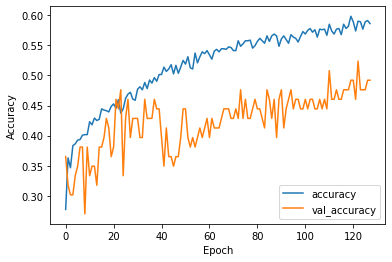

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

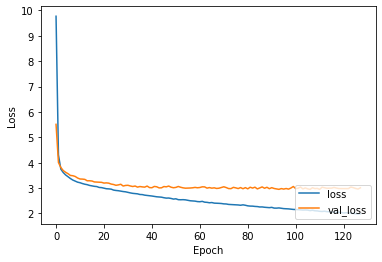

In [31]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [32]:
def count_repeats(output):
    counts = np.unique(np.round(output))
    repeated = NUMBER_NODES - counts.shape[0]
    return repeated

def get_valid_pred(pred):
    valid = np.ones(7)
    labels = np.arange(0, 7)
    for i in labels:
        min_value = np.amin(pred)
        min_idx = np.where(pred == min_value)
        pred[min_idx] = 100
        valid[min_idx] = i
    return valid
    
def get_bandwidth(Graph, nodelist):
    Graph = nx.Graph(Graph)
    if not Graph.edges:
        return 0
    if nodelist.all() != None:
        L = nx.laplacian_matrix(Graph, nodelist=nodelist)
    else:
        L = nx.laplacian_matrix(Graph)
    x, y = np.nonzero(L)
    return (x-y).max()

def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

In [33]:
pred = model.predict(x_test)

sumTest_original = 0
sumTest_pred = 0
sumTest_true = 0

count = 0
cases_with_repetition = 0

for i in range(len(pred)):

    output = pred[i]

    quantity_repeated = count_repeats(np.round(output))
    print('Pred: ', output)
    print('True: ', y_test[i])
    if quantity_repeated != 0:
        cases_with_repetition += 1
    output = get_valid_pred(output)
    print('Pred valid: ', output)
    count += quantity_repeated

    print("Bandwidth")
    graph = getGraph(x_test[i])
    original_band = get_bandwidth(graph, np.array(None))
    sumTest_original += original_band
    pred_band = get_bandwidth(graph, output)
    sumTest_pred += pred_band
    true_band = get_bandwidth(graph, y_test[i])
    sumTest_true += true_band
    print("Bandwidth")
    print(original_band)
    print(pred_band)
    print(true_band)
print('Quantidade de rótulos repetidos, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 6 - ', count)
print('Quantidade de saídas com repetição, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 1 - ', cases_with_repetition)
test_length = pred.shape[0]
print('Test length - ', test_length)
print("Bandwidth mean")
print(sumTest_original / test_length)
print("Pred bandwidth mean")
print(sumTest_pred / test_length)
print("True bandwidth mean")
print(sumTest_true / test_length)

Pred:  [1.7931575 4.7359276 3.13322   2.037022  2.7427144 4.284361  2.7509012]
True:  [1 5 6 0 3 2 4]
Pred valid:  [0. 6. 4. 1. 2. 5. 3.]
Bandwidth
Bandwidth
6
5
2
Pred:  [1.1916145 1.0741861 3.2990327 5.1643944 6.0063877 1.1980203 2.4700518]
True:  [3 0 6 4 5 2 1]
Pred valid:  [1. 0. 4. 5. 6. 2. 3.]
Bandwidth
Bandwidth
6
3
3
Pred:  [3.534951  3.3186119 3.53458   2.441918  1.0313458 3.8261576 3.4790945]
True:  [1 5 6 0 2 4 3]
Pred valid:  [5. 2. 4. 1. 0. 6. 3.]
Bandwidth
Bandwidth
6
4
2
Pred:  [3.1677902 2.3746772 3.8929274 2.6002197 4.120706  2.0640974 2.590518 ]
True:  [2 0 4 6 5 1 3]
Pred valid:  [4. 1. 5. 3. 6. 0. 2.]
Bandwidth
Bandwidth
6
5
2
Pred:  [1.9684292 3.9316428 4.31692   1.7155949 3.538936  2.4838428 3.4264853]
True:  [1 2 6 4 0 5 3]
Pred valid:  [1. 5. 6. 0. 4. 2. 3.]
Bandwidth
Bandwidth
6
3
2
Pred:  [3.6242788 2.0916007 2.2924001 5.769201  3.617352  1.3270857 3.1579716]
True:  [4 0 2 6 5 3 1]
Pred valid:  [5. 1. 2. 6. 4. 0. 3.]
Bandwidth
Bandwidth
6
6
3
Pred:  [2.307512

COM NORMALIZATION 7 7:
Quantidade de rótulos repetidos, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 6 -  241
Quantidade de saídas com repetição, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 1 -  63
Test length -  63
Bandwidth mean
5.904761904761905
Pred bandwidth mean
4.7936507936507935
True bandwidth mean
3.1904761904761907


SEM NORMALIZATION 7 7:
Quantidade de rótulos repetidos, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 6 -  263
Quantidade de saídas com repetição, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 1 -  63
Test length -  63
Bandwidth mean
5.904761904761905
Pred bandwidth mean
4.746031746031746
True bandwidth mean
3.1904761904761907
